,roll_number,arrival_rate,service_rate,avg_waiting_time
0,102303950,1.091601,13.601437,0.004972
1,102303950,9.611683,6.141616,15.508660
2,102303950,8.087898,13.203034,0.095687
3,102303950,4.803771,5.318600,1.585377
4,102303950,1.252240,8.410568,0.014796


,Model,MSE,R2 Score
0,Linear Regression,9.266845,0.378321
1,Decision Tree,1.545091,0.896346
2,Random Forest,0.917386,0.938456
3,SVR,1.704207,0.885671
4,KNN,0.856605,0.942534


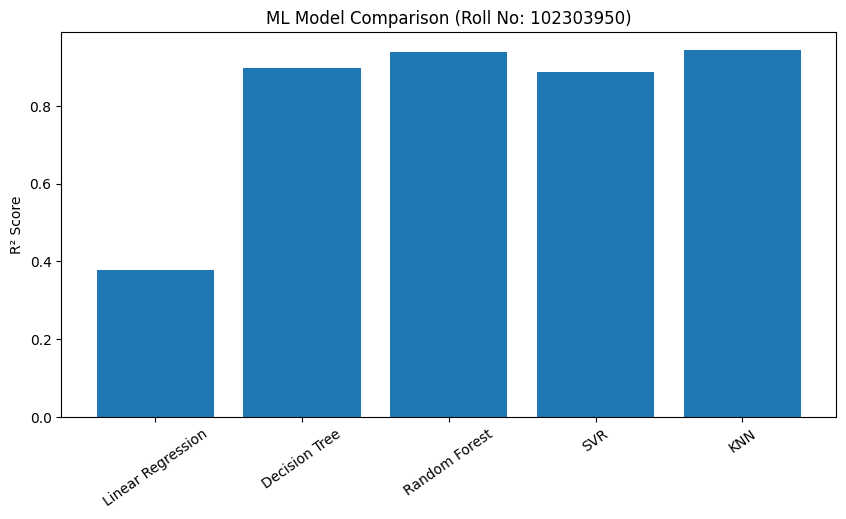

Best Performing Model: KNN


In [3]:
ROLL_NUMBER = 102303950

!pip install simpy

import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

def run_mm1_queue(arrival_rate, service_rate, simulation_time=100):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    wait_times = []

    def customer(env):
        arrival = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival)
            yield env.timeout(random.expovariate(service_rate))

    def arrivals(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrivals(env))
    env.run(until=simulation_time)
    return np.mean(wait_times) if wait_times else 0

random.seed(ROLL_NUMBER)
np.random.seed(ROLL_NUMBER)

records = []
for _ in range(1000):
    lam = random.uniform(1, 10)
    mu = random.uniform(5, 15)
    avg_wait = run_mm1_queue(lam, mu)
    records.append([ROLL_NUMBER, lam, mu, avg_wait])

data = pd.DataFrame(
    records,
    columns=["roll_number", "arrival_rate", "service_rate", "avg_waiting_time"]
)

display(data.head())

X = data[["arrival_rate", "service_rate"]]
y = data["avg_waiting_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=ROLL_NUMBER
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append([
        name,
        mean_squared_error(y_test, preds),
        r2_score(y_test, preds)
    ])

results_df = pd.DataFrame(
    results, columns=["Model", "MSE", "R2 Score"]
)

display(results_df)

plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=35)
plt.ylabel("R² Score")
plt.title(f"ML Model Comparison (Roll No: {ROLL_NUMBER})")
plt.show()

best_model = results_df.loc[results_df["R2 Score"].idxmax(), "Model"]
print(f"Best Performing Model: {best_model}")
